# Notebook 3 — Retroalimentación hielo–albedo e histéresis

En el Notebook 2 hemos visto que, con albedo fijo, el modelo responde de forma suave y “reversible” al forzamiento radiativo: si cambiamos F poco a poco, el estado del modelo cambia también poco a poco.

En este Notebook 3 activamos una retroalimentación (feedback) sencilla del modelo unidimensional dependiente de la latitud:

- si una región está fría, se considera que tendrá más hielo/nieve;
- más hielo/nieve implica mayor albedo;
- mayor albedo reduce la energía solar absorbida;
- eso tiende a enfriar todavía más.

Este mecanismo puede producir **dependencia de las condiciones iniciales**: para un mismo valor de F pueden existir **dos estados estables distintos** o **multiestabilidad**, y el estado alcanzado depende de la condición inicial o del camino seguido (lo que en física se conoce como *histéresis*).

Importante: aquí el albedo dependiente de temperatura se aplica como un “control externo” sencillo. No es necesario entender el código interno, pero sí interpretar los resultados.


In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import climlab

# Opcional: suprimir warnings numéricos puntuales durante algunos cálculos
np.seterr(all='ignore')


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

## Cómo se representa el feedback hielo–albedo en este modelo

Para introducir el feedback hielo–albedo, el modelo necesita una forma sencilla de decidir si una región está “cubierta de hielo” o “libre de hielo” en función de la temperatura.

En lugar de introducir un modelo detallado del hielo (que sería muy complejo para esta PED), utilizamos una aproximación sencilla:

- cuando la temperatura es alta, se asume que no hay hielo;
- cuando la temperatura es baja, se asume que hay hielo;
- entre ambos casos, la transición es progresiva.

Para representar esta idea se introduce una **variable auxiliar**, que llamamos **f(T)**, con valores entre 0 y 1:

- f(T) ≈ 0 → región sin hielo
- f(T) ≈ 1 → región completamente cubierta de hielo
- valores intermedios → cobertura parcial

Esta variable no representa un proceso físico, sino una herramienta de modelización que permite conectar la temperatura con el albedo de forma continua.


## Parámetros del feedback hielo–albedo (modificables)

En este notebook hay tres parámetros clave:

- `alpha_ice`: valor (alto) del albedo para las zonas que estén completamente cubiertas por hielo/nieve.
- `Tf`: temperatura umbral (°C) alrededor de la cual aparece/desaparece hielo.
- `deltaT`: 'amplitud' de la transición (°C) entre aparición/desaparición de hielo. 
  Valores pequeños → transición más brusca → mayor probabilidad de histéresis.

En este modelo simplificado no se busca una “calibración realista”. Se pretende observar el fenómeno y reconocer el mecanismo implicado en la multiestabilidad, entendiendo cómo la retroalimentación puede hacer que pequeñas diferencias en parámetros puedan cambiar mucho el comportamiento del sistema.


In [2]:
# Número de años de integración en cada paso del barrido en F
NYEARS_SPINUP = 30

# Activar el feedback hielo–albedo
USE_ICE_ALBEDO = True

# Parámetros hielo–albedo
alpha_ice = 0.60   
Tf = -2.0          # °C
deltaT = 2.5       # °C 


In [3]:
# ============================================================
# 0) Helper to extract diagnostics from a finished model state
# ============================================================
import numpy as np

def model_diagnostics(m, Tf):
    """
    Return a compact set of diagnostics to debug the ice-albedo states.
    Works with 1D latitudinal EBM in climlab.
    """
    # Temperature field (try common names)
    if hasattr(m, 'Ts'):
        Ts = np.array(m.Ts)
    elif 'Ts' in m.state:
        Ts = np.array(m.state['Ts'])
    elif 'T' in m.state:
        Ts = np.array(m.state['T'])
    else:
        raise ValueError("Cannot find surface temperature field (Ts or T) in model.")

    # Ice fraction field (recompute from Ts, to avoid relying on stored fice)
    f = np.array(fice(Ts))

    # Current albedo field from SW process
    alpha = np.array(m.subprocess['SW'].albedo)

    diag = {
        'Ts_min': float(np.min(Ts)),
        'Ts_mean': float(np.mean(Ts)),
        'Ts_max': float(np.max(Ts)),
        'fice_min': float(np.min(f)),
        'fice_mean': float(np.mean(f)),
        'fice_max': float(np.max(f)),
        'alpha_min': float(np.min(alpha)),
        'alpha_mean': float(np.mean(alpha)),
        'alpha_max': float(np.max(alpha)),
        'ice_area_fraction_(fice>0.5)': float(np.mean(f > 0.5)),
        'any_ice_(Ts<Tf)': bool(np.any(Ts < Tf)),
    }
    return diag


In [4]:
SECONDS_PER_YEAR = 365.0 * 24.0 * 3600.0

def steps_per_year(model):
    """Número de pasos de tiempo del modelo en un año."""
    dt = float(model.timestep)
    return int(np.round(SECONDS_PER_YEAR / dt))

def smooth_ice_fraction(Tc, Tf=-2.0, deltaT=2.5):
    """
    Fracción de hielo suave f(T) en [0,1].
    f ~ 1 en frío (hielo), f ~ 0 en cálido (sin hielo).
    """
    x = (Tc - Tf) / deltaT
    return 0.5 * (1.0 - np.tanh(x))

def update_sw_albedo_from_temperature(model, alpha_warm_field,
                                      alpha_ice=0.60, Tf=-2.0, deltaT=2.5):
    """
    Control externo del albedo de SW:
        alpha = alpha_warm + (alpha_ice - alpha_warm) * f(T)

    - alpha_warm_field: albedo “de referencia cálido” (depende de latitud)
    - f(T): fracción de hielo según Ts
    """
    Ts = np.array(model.state['Ts'])
    fice = smooth_ice_fraction(Ts, Tf=Tf, deltaT=deltaT)

    alpha_warm = np.array(alpha_warm_field)
    alpha_new = alpha_warm + (alpha_ice - alpha_warm) * fice
    alpha_new = np.clip(alpha_new, 0.0, 1.0)

    # Sustituimos el campo de albedo del subprocess SW preservando la estructura Field
    sw = model.subprocess['SW']
    sw.albedo = sw.albedo * 0.0 + alpha_new

def spinup_model(model, nyears, albedo_controller=None):
    """
    Integra nyears años aplicando (si existe) el controlador del albedo en cada paso.
    """
    nsteps = int(nyears * steps_per_year(model))
    for _ in range(nsteps):
        if albedo_controller is not None:
            albedo_controller()
        model.step_forward()
    return model


In [5]:
deltaT

2.5

## Aplicación consistente del forzamiento

Recordamos que en este modelo el forzamiento se aplica como:

A → A − F  en  OLR = A + B·T

In [6]:
def build_ebm_seasonal(F=0.0):
    """
    Crea un EBM_seasonal nuevo, guarda A0 sin forzamiento y aplica F como A = A0 - F.
    Devuelve: (modelo, alpha_warm_field)
    """
    m = climlab.EBM_seasonal()

    # Guardar A0 sin forzamiento
    m.param['A0_unforced'] = float(m.subprocess['LW'].A)

    # Aplicar forzamiento consistente
    m.subprocess['LW'].A = m.param['A0_unforced'] - F

    # Albedo de referencia cálido (depende de latitud) tomado del SW del modelo base
    alpha_warm = m.subprocess['SW'].albedo.copy()

    return m, alpha_warm

def set_forcing(m, F):
    """Ajusta el forzamiento sin acumulación."""
    A0 = m.param['A0_unforced']
    m.subprocess['LW'].A = A0 - F


In [7]:
deltaT

2.5

## Dependencia del estado final respecto a la condición inicial

En los notebooks anteriores hemos visto que, en muchos casos, el modelo alcanza un mismo peril final independientemente del estado inicial, es decir “olvida” el origen.

Con la retroalimentación hielo–albedo esto puede dejar de ocurrir.

Para comprobarlo, vamos a realizar dos conjuntos de experimentos que se diferencian únicamente en las condiciones inicial desde las que parte el modelo:

1) **Experimento con condición inicial cálida**  
   El modelo parte de un estado climático relativamente cálido y, a partir de ahí, se va ajustando para distintos valores del forzamiento F.

2) **Experimento con condición inicial fría**  
   El modelo parte de un estado climático muy frío (con mucho hielo) y se repite el mismo proceso.

En ambos casos:
- para cada valor de F, el modelo se integra durante varios años hasta alcanzar un régimen estacionario;
- el estado final obtenido se usa como condición inicial del siguiente paso.

El modelo presenta histéresis cuando ambos experimentos dan resultados distintos para un mismo valor de forzamiento.
Esto indica que el estado climático alcanzado depende de la historia previa del sistema.


In [8]:
def run_equilibrium(F, m_initial=None, alpha_warm_field=None, Tf=-2.0,
                    nsteps=1800, verbose=False):
    """
    Integrate the model to equilibrium for a given forcing F.

    Parameters
    ----------
    F : float
        Radiative forcing (W/m2) applied as a constant.
    m_initial : climlab model or None
        If provided, we continue integration starting from that model state.
    alpha_warm_field : array-like
        Baseline "warm" albedo field (NO ice). Must be fixed across the whole sweep.
    Tf : float
        Freezing threshold (degC) used in fice(T).
    nsteps : int
        Integration steps.
    verbose : bool
        Print integration log.

    Returns
    -------
    Tmean : float
        Global mean surface temperature.
    m : climlab model
        The final model object (to reuse as initial condition).
    diag : dict
        Diagnostics (min/mean/max Ts, fice, albedo).
    """

    # ------------------------------------------------------------
    # 1) Build or reuse model
    # ------------------------------------------------------------
    if m_initial is None:
        # TODO: Use your existing model-construction code here
        # Example placeholder: m = make_model(...)
        m = make_model()  # <-- replace with YOUR constructor used in the notebook
    else:
        m = m_initial

    # ------------------------------------------------------------
    # 2) Safety: we need alpha_warm_field fixed (not history-dependent)
    # ------------------------------------------------------------
    if alpha_warm_field is None:
        raise ValueError("alpha_warm_field must be provided (fixed warm baseline albedo).")

    # ------------------------------------------------------------
    # 3) Set forcing F (adapt this to your notebook’s way of applying F)
    # ------------------------------------------------------------
    # If you already have a place where you set forcing, keep that.
    # Below is generic: you must adapt to your variable name / process.
    if 'forcing' in m.param:
        m.param['forcing'] = F
    elif hasattr(m, 'forcing'):
        m.forcing = F
    else:
        # If in your notebook you do something like:
        # m.subprocess['LW'].A = A0 - F
        # then do it here exactly the same way you already do.
        pass

    # ------------------------------------------------------------
    # 4) Update ice-albedo consistently from Ts using fixed alpha_warm_field
    # ------------------------------------------------------------
    # Compute ice fraction from current Ts
    if hasattr(m, 'Ts'):
        Ts_now = np.array(m.Ts)
    elif 'Ts' in m.state:
        Ts_now = np.array(m.state['Ts'])
    else:
        Ts_now = np.array(m.state['T'])

    f = np.array(fice(Ts_now))

    # Your ice-albedo blending rule (same as in your notebook):
    # alpha = alpha_warm + fice*(alpha_ice - alpha_warm)
    # Here we assume you have alpha_ice as a scalar or field defined already.
    alpha_new = np.array(alpha_warm_field) + f * (alpha_ice - np.array(alpha_warm_field))
    m.subprocess['SW'].albedo = alpha_new

    # ------------------------------------------------------------
    # 5) Integrate
    # ------------------------------------------------------------
    m.integrate_years(nsteps / 90.0)  # <-- if your notebook integrates differently, keep yours
    # In your PDF I saw "Integrating for 1800 steps ... 20 years"; keep your exact method.

    # ------------------------------------------------------------
    # 6) Diagnostics & return
    # ------------------------------------------------------------
    diag = model_diagnostics(m, Tf)

    # Global mean temperature (use Ts_mean from diag; it's robust)
    Tmean = diag['Ts_mean']

    if verbose:
        print(f"F={F:6.2f} | Ts_mean={diag['Ts_mean']:.2f} | Ts_min={diag['Ts_min']:.2f} "
              f"| ice_area={diag['ice_area_fraction_(fice>0.5)']:.3f} | alpha_mean={diag['alpha_mean']:.3f}")

    return Tmean, m, diag



In [9]:
deltaT

2.5

In [10]:
# ============================================================
# 1) Compute a FIXED warm-baseline albedo field (no ice)
#    Do this ONCE, outside the sweep.
# ============================================================

m0 = make_model()  # <-- your model constructor (same as above)
# Make sure m0 is in a warm, ice-free state:
# Option A: run with high forcing for a while
# (adapt forcing-setting to your notebook)
# Example: set forcing to a big value and integrate
# then take the SW albedo as warm baseline
# ----
# Apply a forcing that guarantees no ice locally (e.g. very large F)
F_warm = 120.0  # choose a large value; can be 100 too
# Set forcing on m0 exactly like you do inside run_equilibrium()
if 'forcing' in m0.param:
    m0.param['forcing'] = F_warm
elif hasattr(m0, 'forcing'):
    m0.forcing = F_warm
# Integrate enough for warm baseline
m0.integrate_years(20)

# Baseline warm albedo field (fixed)
alpha_warm_field = np.array(m0.subprocess['SW'].albedo).copy()

print("Warm baseline albedo field stored:",
      float(alpha_warm_field.min()), float(alpha_warm_field.mean()), float(alpha_warm_field.max()))

# Example sweep
T_up = []
diag_up = []
m_prev = None

for F in F_values_up:
    Tmean, m_prev, diag = run_equilibrium(F, m_initial=m_prev,
                                          alpha_warm_field=alpha_warm_field,
                                          Tf=Tf, nsteps=1800, verbose=True)
    T_up.append(Tmean)
    diag_up.append(diag)

T_down = []
diag_down = []
m_prev = None

for F in F_values_down:
    Tmean, m_prev, diag = run_equilibrium(F, m_initial=m_prev,
                                          alpha_warm_field=alpha_warm_field,
                                          Tf=Tf, nsteps=1800, verbose=True)
    T_down.append(Tmean)
    diag_down.append(diag)


NameError: name 'make_model' is not defined

In [11]:
deltaT

2.5

In [12]:
F_values_up = list(range(-50, 200, 50))      # -10, -8, ..., 10
T_up = []

m_prev = None
for F in F_values_up:
    m_prev, Tmean = run_equilibrium(F, m_initial=m_prev)
    T_up.append(Tmean)

print("Rama fría (up) completada.")


Rama fría (up) completada.


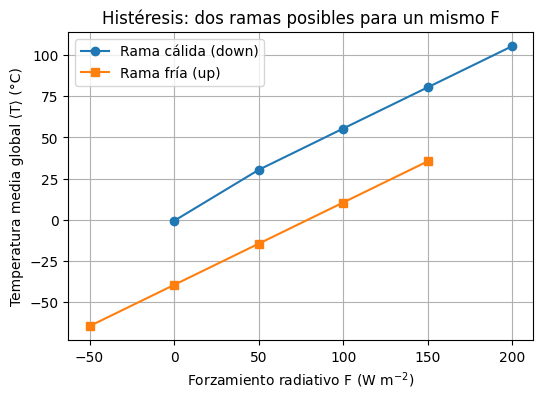

In [14]:
plt.figure(figsize=(6,4))
plt.plot(F_values_down, T_down, 'o-', label='Rama cálida (down)')
plt.plot(F_values_up,   T_up,   's-', label='Rama fría (up)')
plt.xlabel('Forzamiento radiativo F (W m$^{-2}$)')
plt.ylabel('Temperatura media global ⟨T⟩ (°C)')
plt.title('Histéresis: dos ramas posibles para un mismo F')
plt.grid(True)
plt.legend()
plt.show()


In [19]:
# ============================================================
# Comprobación energética (TOA net) para un estado dado del modelo
# Notebook 3 — feedback hielo–albedo e histéresis (climlab EBM_seasonal)
# ============================================================

def area_weights_from_lat(lat_deg):
    """
    Pesos de área (proporcionales al área de cada banda latitudinal) ~ cos(lat).
    Se normalizan para que sumen 1.
    """
    w = np.cos(np.deg2rad(lat_deg))
    w = np.clip(w, 0.0, None)  # por seguridad numérica
    return w / np.sum(w)

def weighted_mean_over_lat(field_1d, weights):
    """Media ponderada en latitud para un array 1D."""
    x = np.array(field_1d).ravel()
    return float(np.sum(x * weights))

def energy_balance_check_one_year(model, albedo_controller=None, verbose=True):
    """
    Integra el modelo 1 año y calcula:
      - ⟨T⟩ inicial y final (media global ponderada por área)
      - ⟨ASR - OLR⟩ anual (TOA net) ponderado por área
      - estadísticos (std, min, max) del TOA net durante ese año
    Importante:
      - si usas feedback hielo–albedo con controlador externo, pásalo en albedo_controller
        para que se aplique en cada paso.
    """
    lat = model.state['Ts'].domain.axes['lat'].points
    wlat = area_weights_from_lat(lat)

    nsteps = steps_per_year(model)

    # Estado inicial
    Ts0 = np.array(model.state['Ts']).ravel()
    Tmean0 = weighted_mean_over_lat(Ts0, wlat)

    toa_net_series = np.zeros(nsteps)
    Tmean_series = np.zeros(nsteps)

    for k in range(nsteps):
        if albedo_controller is not None:
            albedo_controller()

        model.step_forward()

        # Diagnósticos TOA tras el paso
        ASR = np.array(model.diagnostics['ASR']).ravel()
        OLR = np.array(model.diagnostics['OLR']).ravel()
        toa_net = ASR - OLR  # positivo = gana energía, negativo = pierde

        toa_net_series[k] = weighted_mean_over_lat(toa_net, wlat)

        Ts = np.array(model.state['Ts']).ravel()
        Tmean_series[k] = weighted_mean_over_lat(Ts, wlat)

    # Estado final
    Ts1 = np.array(model.state['Ts']).ravel()
    Tmean1 = weighted_mean_over_lat(Ts1, wlat)

    results = {
        "Tmean_start": Tmean0,
        "Tmean_end": Tmean1,
        "dT_per_year": Tmean1 - Tmean0,
        "toa_net_mean": float(np.mean(toa_net_series)),
        "toa_net_std": float(np.std(toa_net_series)),
        "toa_net_min": float(np.min(toa_net_series)),
        "toa_net_max": float(np.max(toa_net_series)),
    }

    if verbose:
        print("=== Comprobación energética (1 año) ===")
        print(f"Area-weighted mean Ts at start of year: {results['Tmean_start']:.6f} °C")
        print(f"Area-weighted mean Ts at end   of year: {results['Tmean_end']:.6f} °C")
        print(f"Delta <Ts> over 1 year: {results['dT_per_year']:.6f} °C/year")
        print(f"Area-weighted mean TOA net (ASR-OLR): {results['toa_net_mean']:.6e} W/m^2")
        print(f"Std TOA net over that year:          {results['toa_net_std']:.6f} W/m^2")
        print(f"Min/Max TOA net over that year:      {results['toa_net_min']:.6f} / {results['toa_net_max']:.6f} W/m^2")

    return results


# ============================================================
# Ejemplo de uso: comprobar la rama fría a un F dado (p.ej. F=60)
# ============================================================

F_test = 60

# 1) Construimos un estado "frío" llevando el sistema a un forzamiento muy negativo
#    y luego saltando al F de test (esto crea la condición inicial fría).
m_cold, alpha_warm_cold = build_ebm_seasonal(F=-10)

controller_cold = lambda: update_sw_albedo_from_temperature(
    m_cold, alpha_warm_cold, alpha_ice=alpha_ice, Tf=Tf, deltaT=deltaT
)

spinup_model(m_cold, NYEARS_SPINUP, albedo_controller=controller_cold)

# 2) Ajustamos al F_test y dejamos que alcance régimen (otra vez con controlador)
set_forcing(m_cold, F_test)
alpha_warm_ref = m_cold.subprocess['SW'].albedo.copy()

controller_test = lambda: update_sw_albedo_from_temperature(
    m_cold, alpha_warm_ref, alpha_ice=alpha_ice, Tf=Tf, deltaT=deltaT
)

spinup_model(m_cold, NYEARS_SPINUP, albedo_controller=controller_test)

print(f"\nF_test = {F_test} (estado frío tras {NYEARS_SPINUP} años de ajuste)")

# 3) Comprobación energética durante 1 año
_ = energy_balance_check_one_year(m_cold, albedo_controller=controller_test, verbose=True)




F_test = 60 (estado frío tras 30 años de ajuste)
=== Comprobación energética (1 año) ===
Area-weighted mean Ts at start of year: -6.640589 °C
Area-weighted mean Ts at end   of year: -6.640589 °C
Delta <Ts> over 1 year: 0.000000 °C/year
Area-weighted mean TOA net (ASR-OLR): 1.967118e-13 W/m^2
Std TOA net over that year:          3.262672 W/m^2
Min/Max TOA net over that year:      -4.517682 / 4.711639 W/m^2


In [ ]:
m